In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from icu_mortality_prediction import DATA_DIR

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


# DEBUG START

In [123]:
lab_events_raw_df = pd.read_csv(os.path.join(DATA_DIR, 'raw','D_LABITEMS.csv'))


In [126]:
lab_events_raw_df[lab_events_raw_df['LABEL']=='pH'].head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
147,21,50820,pH,Blood,Blood Gas,11558-4
158,32,50831,pH,Other Body Fluid,Blood Gas,2748-2
420,294,51094,pH,Urine,Chemistry,2756-5
690,691,51491,pH,Urine,Hematology,5803-2


# DEBUG STOP

In [2]:
lab_events_filename = 'LAB_EVENTS_FIRST24.csv'
lab_events_filepath = os.path.join(DATA_DIR, 'interim',lab_events_filename)
lab_events_data_df = pd.read_csv(lab_events_filepath) #, index_col = 'icustay_id')

lab_events_data_df.loc[:,'charttime']  = pd.to_datetime(lab_events_data_df.loc[:,'charttime'])
lab_events_data_df = lab_events_data_df.sort_values(['icustay_id', 'charttime'],ascending=True)
# lab_events_data_df.drop(['charttime'], axis=1, inplace=True)
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


In [3]:
# Creates column name variables. 
lab_value = 'valuenum'
lab_label = 'label'
gender = 'gender'
label = 'label'
valuenum = 'valuenum'
hospital_expire_flag = 'hospital_expire_flag'


In [5]:
# Creates copy of the lab_events_data_df dataframe for visualization exploration
aggregate_lab_values_for_visualization_df = lab_events_data_df[[gender, 
                                                             hospital_expire_flag, 
                                                            label, 
                                                            valuenum]]

In [6]:
# Generates counts for different types of lab measurements
lab_measurement_type_counts = aggregate_lab_values_for_visualization_df['label'].value_counts()


lab_measurement_type_counts

pH                            218882
Hematocrit                    166293
White Blood Cells             130909
Creatinine                    130258
Glucose                       119726
Lactate                        88289
Oxygen Saturation              61903
Lactate Dehydrogenase (LD)     19261
Creatinine, Urine               7397
WBC Count                        177
24 hr Creatinine                  21
Urine Creatinine                   4
Name: label, dtype: int64

In [7]:
# Create a list of lab measurement types with counts greater than 5k. 
# Removes sparse lab values. 
lab_measurement_types = list(lab_measurement_type_counts[
                                        lab_measurement_type_counts>5000
                                                        ].index)


In [8]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

# DEBUG START

In [ ]:
dead.head()

In [ ]:
lab_measurement_types

In [ ]:
lab_measurement = 'Urine Creatinine'
aggregate_lab_values_for_visualization[
                                 (aggregate_lab_values_for_visualization[label]==lab_measurement)

In [ ]:
gender_values = ['M', 'F']
gend = gender_values[0]
lab_measurement = 'Urine Creatinine' #lab_measurement_types[0]
dead = aggregate_lab_values_for_visualization[
                                 (aggregate_lab_values_for_visualization[label]==lab_measurement) #&             
#                                  (aggregate_lab_values_for_visualization[hospital_expire_flag]==1)& 
#                                  (aggregate_lab_values_for_visualization[gender] == gend)
                                ]

In [ ]:
for 
aggregate_lab_values_for_visualization[
                                 (aggregate_lab_values_for_visualization[label]==lab_measurement)
].shape

In [ ]:
dead

# DEBUG STOP

pH
Hematocrit
White Blood Cells
Creatinine
Glucose
Lactate
Oxygen Saturation
Lactate Dehydrogenase (LD)
Creatinine, Urine


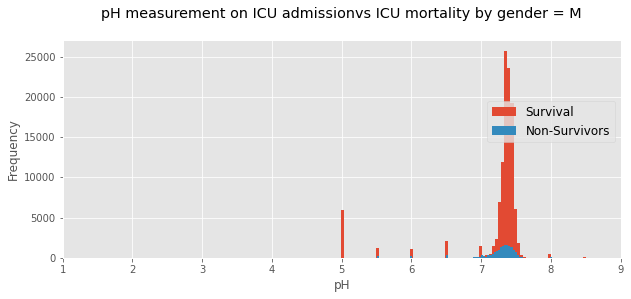

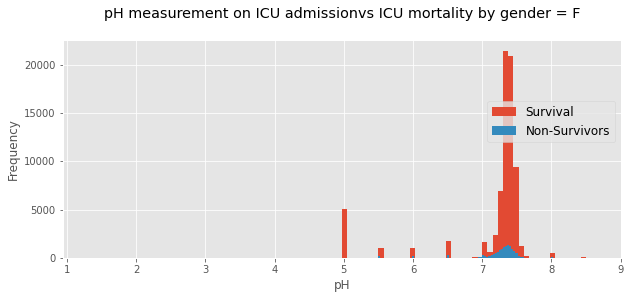

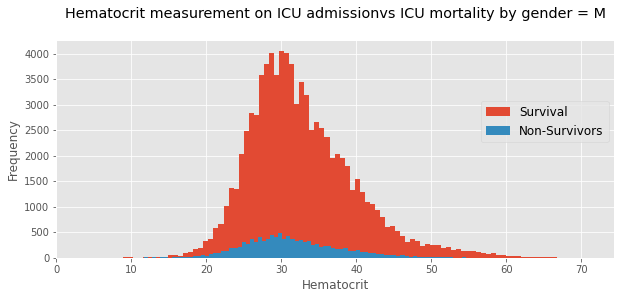

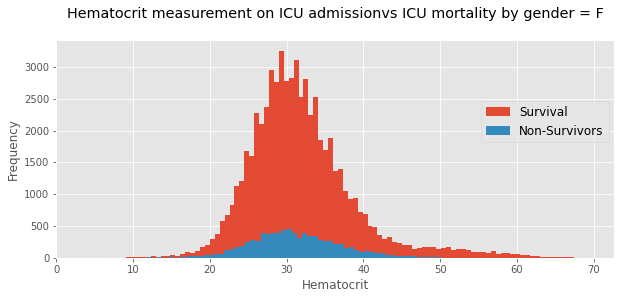

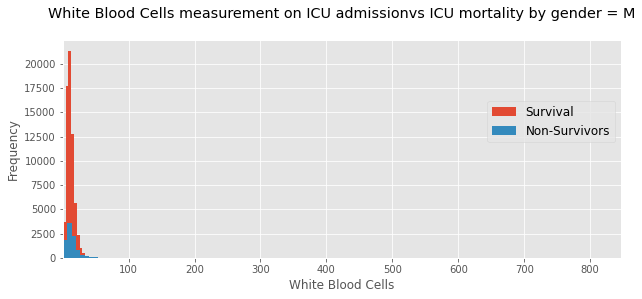

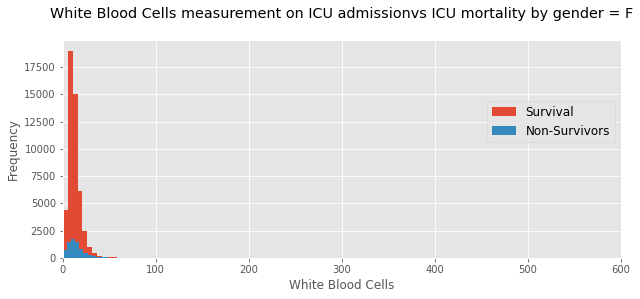

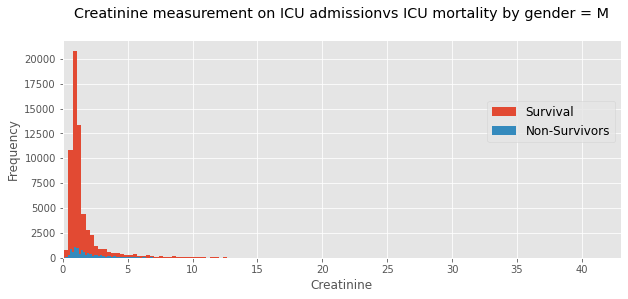

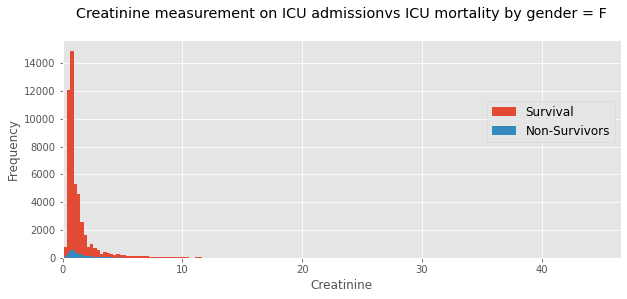

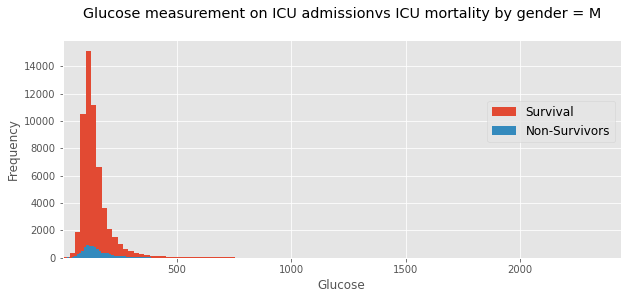

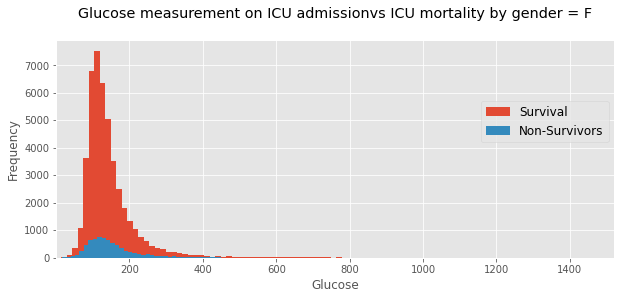

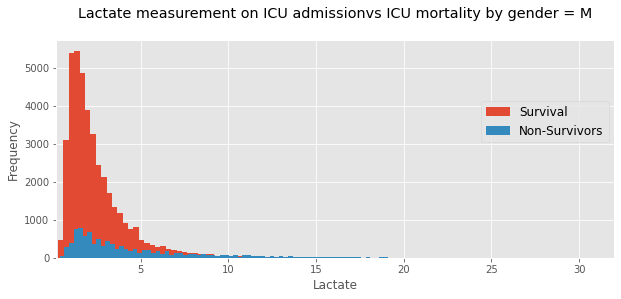

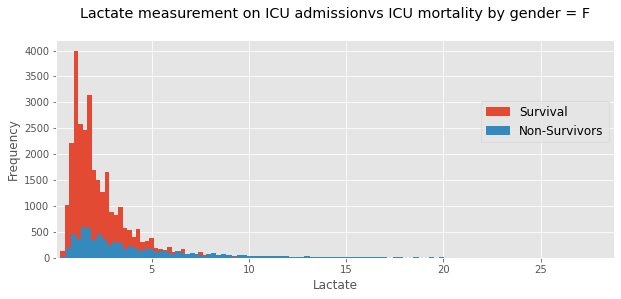

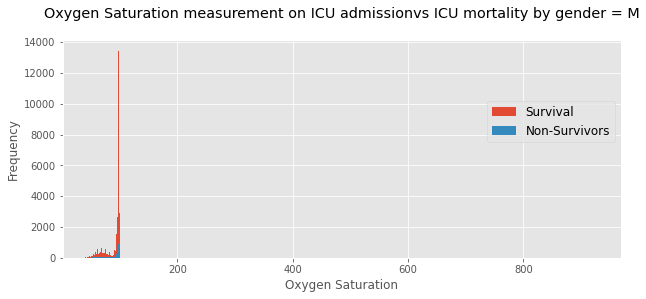

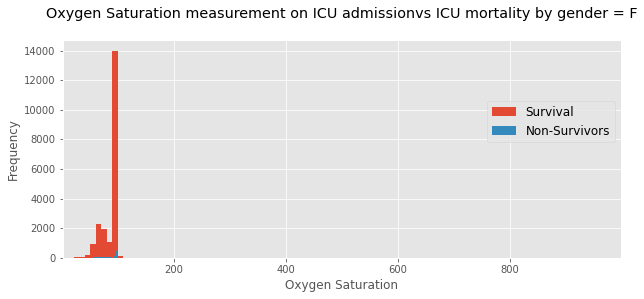

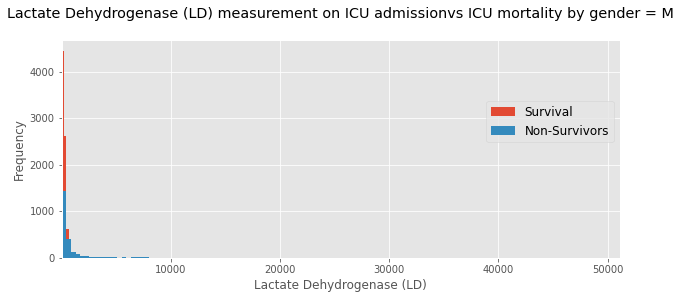

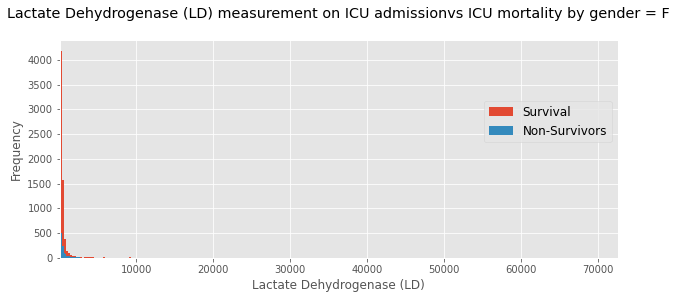

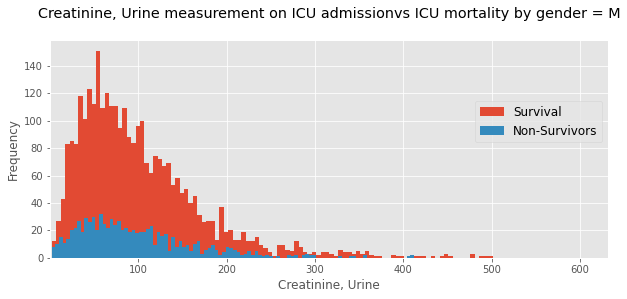

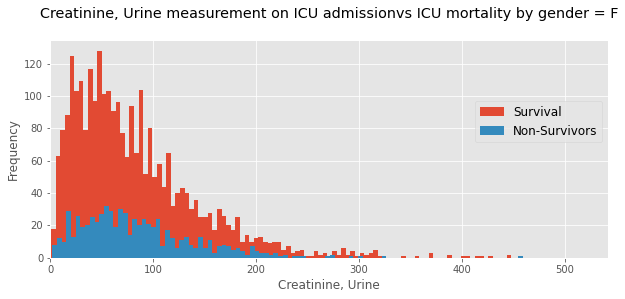

In [10]:
gender_values = ['M', 'F']

for lab_measurement in lab_measurement_types:
    print(lab_measurement)
    for gend in gender_values:
     
        
        #print gend
        dead = aggregate_lab_values_for_visualization_df[
                                 (aggregate_lab_values_for_visualization_df[label]==lab_measurement)&             
                                 (aggregate_lab_values_for_visualization_df[hospital_expire_flag]==1)& 
                                 (aggregate_lab_values_for_visualization_df[gender] == gend)
                                ]
        dead.name = 'Non_Survivors'
        
        live = aggregate_lab_values_for_visualization_df[
                                 (aggregate_lab_values_for_visualization_df[label]==lab_measurement)&             
                                 (aggregate_lab_values_for_visualization_df[hospital_expire_flag]==0)& 
                                 (aggregate_lab_values_for_visualization_df[gender] == gend)
                                ]                       
        live.name = 'Survivors'
        
        live_max = live[lab_value].dropna().max()#quantile(0.999)
        live_min = live[lab_value].dropna().min()#quantile(0.001)
        dead_max = dead[lab_value].dropna().max()#quantile(0.999)
        dead_min = dead[lab_value].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
#         print("survivor max = {}    survivor min = {}".format(live_max, live_min))
#         print("expired max = {}    expired min = {}".format(dead_max, dead_min))
        plt.subplots(figsize=(10,4))
        live[(live[lab_value] < live_max) & (live[lab_value] > live_min)][lab_value].plot.hist(
                                                                            bins=100, 
                                                                            alpha=1.0,
                                                                            label='Survival')
    
        dead[(dead[lab_value] < dead_max) & (dead[lab_value] > dead_min)][lab_value].plot.hist(
                                                                            bins=100,
                                                                            alpha=1.0,
                                                                            label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(lab_measurement) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(lab_measurement)
        plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)
#     print("\n\n")

In [11]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

# Individual Lab Measurement Exploration

### pH

Removing values above 8 and below 6.5
Normal cellular metabolism and function require that blood pH be maintained within narrow limits, 
7.35-7.45. Even mild excursion outside this range has deleterious effect, 
and pH of less than 6.8 or greater than 7.8 is considered – according to medical and physiology texts – 
incompatible with life. 
Such a view is challenged by the detail of a recently published case report, 
which describes survival of a patient whose pH was just 6.53
https://acutecaretesting.org/en/journal-scans/record-breaking-blood-ph-survival-following-extreme-acidosis

In [110]:
pH_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'pH'
][lab_value]

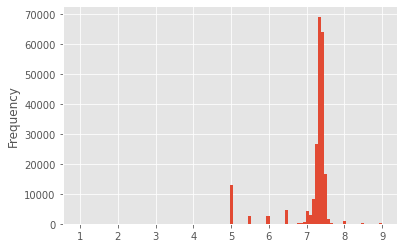

In [114]:
pH_values_series.plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='pH')
# plt.xlim(minlim, 100)

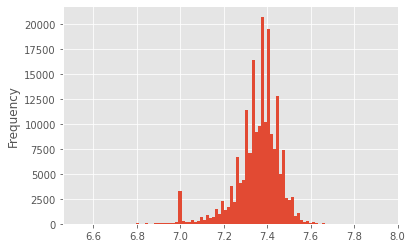

In [127]:
pH_values_series[(pH_values_series<8.0)&
                 (pH_values_series>6.5)
                ].plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='pH')
# plt.xlim(minlim, 100)

(6.5, 8.5)

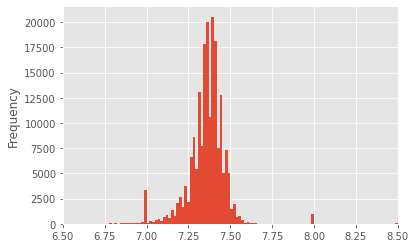

In [120]:
pH_values_series.plot.hist(
                        bins=500, 
                        alpha=1.0,
                        label='pH', 
)
plt.xlim(6.5,8.5)

In [41]:
count, division = pd.np.histogram(wbc_values_series.dropna(), bins=1000)

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [44]:
print(pd.Series(count, division[:-1]).to_string())

0.0000       1392
1.6934       2928
3.3868       6620
5.0802      12462
6.7736      16553
8.4670      17929
10.1604     16537
11.8538     13931
13.5472     10800
15.2406      8179
16.9340      6032
18.6274      4552
20.3208      3164
22.0142      2391
23.7076      1687
25.4010      1179
27.0944       944
28.7878       676
30.4812       551
32.1746       399
33.8680       293
35.5614       243
37.2548       201
38.9482       149
40.6416       110
42.3350        95
44.0284        70
45.7218        79
47.4152        69
49.1086        46
50.8020        39
52.4954        33
54.1888        31
55.8822        32
57.5756        33
59.2690        22
60.9624        20
62.6558        22
64.3492        14
66.0426        19
67.7360        13
69.4294        11
71.1228        10
72.8162        14
74.5096         8
76.2030        11
77.8964         7
79.5898         9
81.2832         6
82.9766        10
84.6700         6
86.3634         7
88.0568         7
89.7502         5
91.4436         9
93.1370   

### WBC Values

In [64]:
wbc_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'White Blood Cells'
][lab_value]

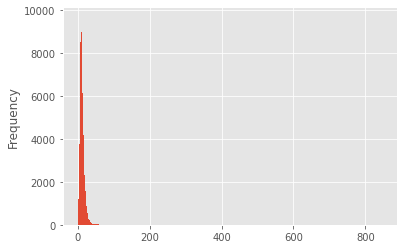

In [67]:
wbc_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        label='Survival')
# plt.xlim(minlim, 100)

(0.0, 100.0)

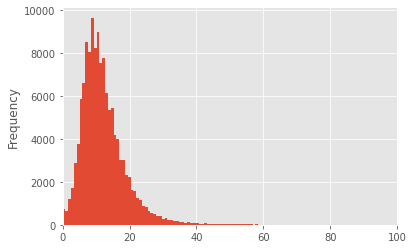

In [68]:
wbc_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        label='Survival', 
)
plt.xlim(minlim, 100)

In [41]:
count, division = pd.np.histogram(wbc_values_series.dropna(), bins=1000)

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [44]:
print(pd.Series(count, division[:-1]).to_string())

0.0000       1392
1.6934       2928
3.3868       6620
5.0802      12462
6.7736      16553
8.4670      17929
10.1604     16537
11.8538     13931
13.5472     10800
15.2406      8179
16.9340      6032
18.6274      4552
20.3208      3164
22.0142      2391
23.7076      1687
25.4010      1179
27.0944       944
28.7878       676
30.4812       551
32.1746       399
33.8680       293
35.5614       243
37.2548       201
38.9482       149
40.6416       110
42.3350        95
44.0284        70
45.7218        79
47.4152        69
49.1086        46
50.8020        39
52.4954        33
54.1888        31
55.8822        32
57.5756        33
59.2690        22
60.9624        20
62.6558        22
64.3492        14
66.0426        19
67.7360        13
69.4294        11
71.1228        10
72.8162        14
74.5096         8
76.2030        11
77.8964         7
79.5898         9
81.2832         6
82.9766        10
84.6700         6
86.3634         7
88.0568         7
89.7502         5
91.4436         9
93.1370   

### Creatinine Values

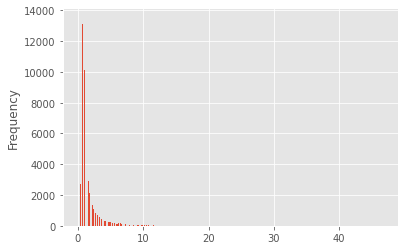

In [69]:
creatinine_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Creatinine'
][lab_value]

creatinine_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        label='Survival')
# plt.xlim(minlim, 100)

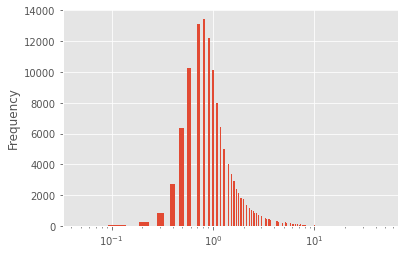

In [71]:
creatinine_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        logx=True, 
                        label='Survival'
) 
                        
# plt.xlim(minlim, 100)

In [50]:
creatinine_values_series = aggregate_lab_values_for_visualization_df[
    aggregate_lab_values_for_visualization_df[lab_label]== 'Creatinine'
    ][lab_value]

In [51]:
count, division = pd.np.histogram(creatinine_values_series.dropna(), bins=500)

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [52]:
print(pd.Series(count, division[:-1]).to_string())

0.0000         8
0.0932        79
0.1864       263
0.2796       861
0.3728      2744
0.4660      6342
0.5592     10271
0.6524     13116
0.7456     13450
0.8388     12213
0.9320     10134
1.0252      7986
1.1184      6429
1.2116      4972
1.3048         0
1.3980      4052
1.4912      3408
1.5844      2905
1.6776      2381
1.7708      2114
1.8640      1847
1.9572      1735
2.0504      1387
2.1436      1375
2.2368      1147
2.3300      1070
2.4232      1005
2.5164       843
2.6096       853
2.7028         0
2.7960       721
2.8892       629
2.9824       679
3.0756       577
3.1688       564
3.2620       549
3.3552       485
3.4484       453
3.5416       459
3.6348       387
3.7280       382
3.8212       387
3.9144       368
4.0076       307
4.1008         0
4.1940       312
4.2872       294
4.3804       257
4.4736       280
4.5668       274
4.6600       256
4.7532       226
4.8464       241
4.9396       217
5.0328       214
5.1260       239
5.2192       204
5.3124       193
5.4056        

### 'Glucose' Values

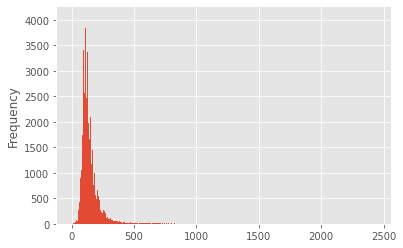

In [72]:
glucose_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Glucose'
][lab_value]

glucose_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        label='Survival')
# plt.xlim(minlim, 100)

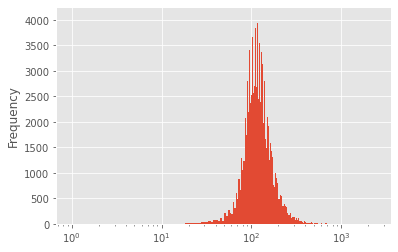

In [73]:
glucose_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        logx=True, 
                        label='Survival'
) 
                        
# plt.xlim(minlim, 100)

### Lactate 

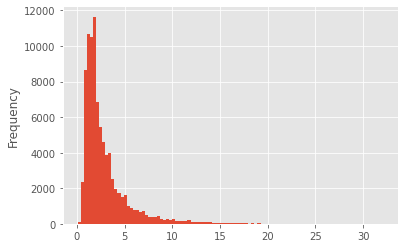

In [79]:
lactate_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Lactate'
][lab_value]

lactate_values_series.plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='Lactate')
# plt.xlim(minlim, 100)

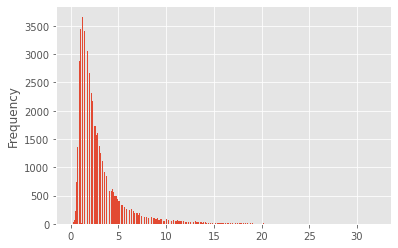

In [81]:
lactate_values_series.plot.hist(
                        bins=500, 
                        alpha=1.0,
                        label='Lactate')
# plt.xlim(minlim, 100)

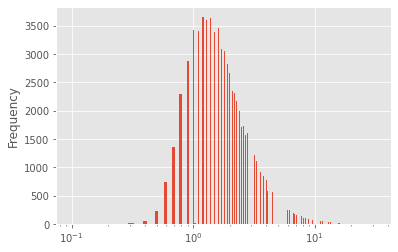

In [84]:
lactate_values_series.plot.hist(
                        bins=1000, 
                        alpha=1.0,
                        logx=True, 
                        label='Lactate'
) 
                        
# plt.xlim(minlim, 100)

### Oxygen Saturation

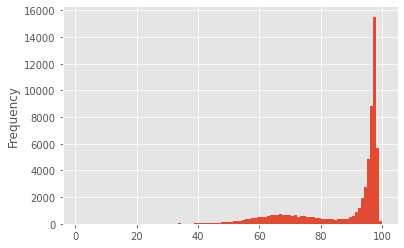

In [95]:
o2sat_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Oxygen Saturation'
][lab_value]

#02 Saturation is a percent and can't be above 100
o2sat_values_series = o2sat_values_series[o2sat_values_series<=100]

o2sat_values_series.plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='Oxygen Saturation')
# plt.xlim(minlim, 100)

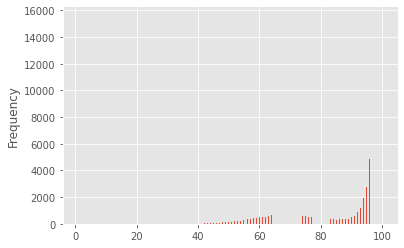

In [96]:
o2sat_values_series.plot.hist(
                        bins=500, 
                        alpha=1.0,
                        label='Oxygen Saturation')
# plt.xlim(minlim, 100)

In [92]:
count, division = pd.np.histogram(o2sat_values_series.dropna(), bins=1000)
print(pd.Series(count, division[:-1]).to_string())

0.9000          8
1.8971          0
2.8942          1
3.8913          1
4.8884          1
5.8855          1
6.8826          0
7.8797          1
8.8768          3
9.8739          0
10.8710         1
11.8681         0
12.8652         1
13.8623         0
14.8594         3
15.8565         0
16.8536         3
17.8507         1
18.8478         4
19.8449         4
20.8420         2
21.8391         5
22.8362         5
23.8333         3
24.8304         7
25.8275         5
26.8246        12
27.8217        11
28.8188         5
29.8159        11
30.8130        11
31.8101        20
32.8072        16
33.8043        24
34.8014        15
35.7985        18
36.7956        20
37.7927        20
38.7898        37
39.7869        40
40.7840        33
41.7811        36
42.7782        60
43.7753        73
44.7724        76
45.7695        66
46.7666        78
47.7637       114
48.7608       119
49.7579       130
50.7550       158
51.7521       190
52.7492       220
53.7463       240
54.7434       255
55.7405   

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


### Lactate Dehydrogenase (LD)

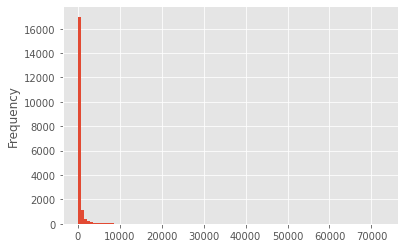

In [98]:
lactate_dehydrogenase_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Lactate Dehydrogenase (LD)'
][lab_value]

lactate_dehydrogenase_values_series.plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='Lactate')
# plt.xlim(minlim, 100)

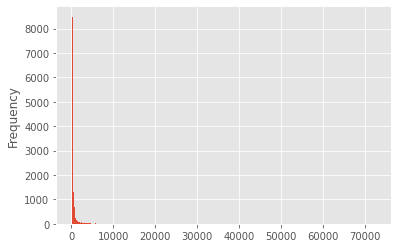

In [99]:
lactate_dehydrogenase_values_series.plot.hist(
                        bins=500, 
                        alpha=1.0,
                        label='Lactate')
# plt.xlim(minlim, 100)

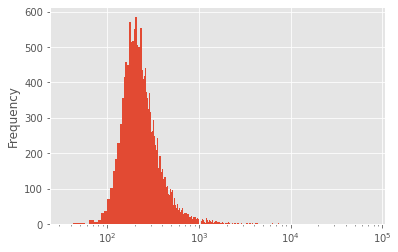

In [104]:
lactate_dehydrogenase_values_series.plot.hist(
                        bins=10000, 
                        alpha=1.0,
                        logx=True, 
                        label='Lactate'
) 
                        
# plt.xlim(minlim, 100)

In [101]:
count, division = pd.np.histogram(lactate_dehydrogenase_values_series.dropna(), bins=1000)
print(pd.Series(count, division[:-1]).to_string())

35.000        173
107.552      3194
180.104      5071
252.656      3417
325.208      1955
397.760      1173
470.312       808
542.864       512
615.416       370
687.968       311
760.520       218
833.072       202
905.624       173
978.176        47
1050.728      104
1123.280       96
1195.832       89
1268.384       74
1340.936       74
1413.488       56
1486.040       55
1558.592       45
1631.144       42
1703.696       42
1776.248       37
1848.800       36
1921.352       33
1993.904       32
2066.456       29
2139.008       23
2211.560       16
2284.112       25
2356.664       28
2429.216       26
2501.768       16
2574.320       24
2646.872       23
2719.424       15
2791.976       15
2864.528       11
2937.080       14
3009.632        9
3082.184       10
3154.736        9
3227.288        8
3299.840       16
3372.392       10
3444.944       10
3517.496       11
3590.048       10
3662.600        9
3735.152       10
3807.704       11
3880.256        5
3952.808        7
4025.360  

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [105]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

### Creatinine, Urine

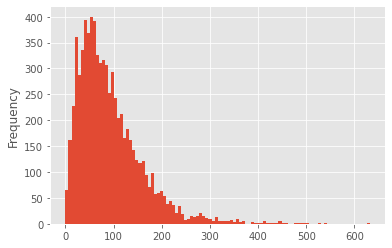

In [106]:
uring_creatinine_values_series = aggregate_lab_values_for_visualization_df[
aggregate_lab_values_for_visualization_df[lab_label]== 'Creatinine, Urine'
][lab_value]

uring_creatinine_values_series.plot.hist(
                        bins=100, 
                        alpha=1.0,
                        label='Creatinine, Urine')
# plt.xlim(minlim, 100)

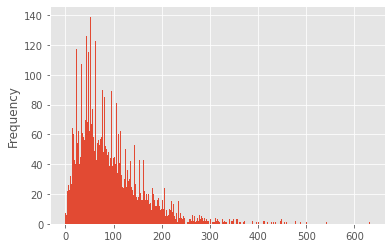

In [109]:
uring_creatinine_values_series.plot.hist(
                        bins=500, 
                        alpha=1.0, 
                        label='Creatinine, Urine'
) 
                        
# plt.xlim(minlim, 100)

In [101]:
count, division = pd.np.histogram(lactate_dehydrogenase_values_series.dropna(), bins=1000)
print(pd.Series(count, division[:-1]).to_string())

35.000        173
107.552      3194
180.104      5071
252.656      3417
325.208      1955
397.760      1173
470.312       808
542.864       512
615.416       370
687.968       311
760.520       218
833.072       202
905.624       173
978.176        47
1050.728      104
1123.280       96
1195.832       89
1268.384       74
1340.936       74
1413.488       56
1486.040       55
1558.592       45
1631.144       42
1703.696       42
1776.248       37
1848.800       36
1921.352       33
1993.904       32
2066.456       29
2139.008       23
2211.560       16
2284.112       25
2356.664       28
2429.216       26
2501.768       16
2574.320       24
2646.872       23
2719.424       15
2791.976       15
2864.528       11
2937.080       14
3009.632        9
3082.184       10
3154.736        9
3227.288        8
3299.840       16
3372.392       10
3444.944       10
3517.496       11
3590.048       10
3662.600        9
3735.152       10
3807.704       11
3880.256        5
3952.808        7
4025.360  

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [ ]:
'Lactate Dehydrogenase (LD)

# DEBUG STOP

In [ ]:
aggregate_lab_values_for_visualization[
    aggregate_lab_values_for_visualization[lab_label]== 'Glucose'
    
][lab_valuenum].describe()


In [ ]:
aggregate_lab_values_for_visualization[
    (aggregate_lab_values_for_visualization[lab_label]== 'Glucose') #&
#      (aggregate_lab_values_for_visualization[lab_value]>1000)
    
][lab_value].plot.hist(bins=100)


In [ ]:
aggregate_lab_values_for_visualization[
    (aggregate_lab_values_for_visualization[lab_label]== 'Glucose')&
    (aggregate_lab_values_for_visualization[lab_value]>1000)
    
][lab_value].describe()


In [ ]:
  
# for col in dummy.keys():
    
#     col2 = dummy[col].columns[0]
    
#     gender = ['M', 'F'] 
    
#     for gend in gender:
        
#         #print gend
#         dead = lab_events_data_df[lab_events_data_df[
#                              (hospital_expire_flag == 1)&
#                               (dummy[col].gender == gend)]
#                           #&(const_dict[col][col2] >20)]
#         dead.name = 'Non_Survivors'
#         live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
#                               (dummy[col].gender == gend)]
#                           #&(const_dict[col][col2] >20)]
#         live.name = 'Survivors'
    
    
    
    
    
#     #dummy = mean_dict[key][mean_dict[key].gender == 'F']
#     #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
#     #                                   left_index = True, right_index = True, how='left', sort = True)
    
#         maxx = 0.99
#         minn = 0.01
    
#         live_max = live[col2].dropna().max()#quantile(0.999)
#         live_min = live[col2].dropna().min()#quantile(0.001)
#         dead_max = dead[col2].dropna().max()#quantile(0.999)
#         dead_min = dead[col2].dropna().min()#quantile(0.001)
#         maxlim = max(live_max, dead_max)
#         minlim = min(live_min, dead_min)
   
        
#         plt.subplots(figsize=(10,4))
#         live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
#                                                                             alpha=1.0,label='Survival')
    
#         dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
#                                                                             alpha=1.0,label='Non-Survivors')
#         # add title, labels etc.
#         plt.title('{} measurement on ICU admission'.format(col) + 
#                    'vs ICU mortality by gender = {}\n'.format(gend))
#         plt.xlabel(col)
#         plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
#         #print "{}    {}".format(maxlim, minlim)
#         plt.xlim(minlim, maxlim)

### DEBUG STOP

## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [ ]:
# print("loading lab data")
# lab_events_data_df['subject_id'] = lab_events_data_df.index
# lab_events_data_df.set_index(np.arange(lab_events_data_df.shape[0]), inplace = True)
# cols = list(lab_events_data_df.columns)
# cols.insert(0, cols.pop(cols.index('icustay_id')))
# cols.insert(1, cols.pop(cols.index('subject_id')))
# lab_events_data_df = lab_events_data_df[cols]
# print("complete")

In [ ]:
unique_icu_stay_count = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first').shape[0]
unique_patients_count = lab_events_data_df.drop_duplicates('subject_id', keep = 'first').shape[0]

print("The number of unique ICU stays = {}".format(unique_icu_stay_count))
print("The number of unique patients  = {}\n".format(unique_patients_count))

# display the different measurements captured in the database query
labels = lab_events_data_df.label.unique()
print("Lab measurements inlcude/n")
print(labels)
# display(lab_events_data_df.shape)
print("Example lab values for Lactate:")
display(lab_events_data_df[(lab_events_data_df.label=='Lactate') & (~(lab_events_data_df.valuenum.isnull()))].head())



## Assessing Feature Prevalence


# DEBUG START 

In [ ]:
test_merged_pivot_df.head()

In [ ]:
test_merged_pivot_df[~test_merged_pivot_df['Hematocrit'].isna()][['icustay_id','Hematocrit']].groupby('icustay_id').first()


# DEBUG STOP

In [ ]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    lab_count = lab_events_data_df['icustay_id'][lab_events_data_df['label'] == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print("{}    {}".format(item, lab_count)) #, num_measures)
    if lab_count > 6000:
        print("adding {}".format(item))
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

## CALCULATE NUMBER OF SAMPLES FOR EACH FEATURE

In [ ]:
labels2[0]

In [ ]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

lab_counts_df =  lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    groupby_counts = lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    groupby_counts.columns = [item]
    lab_counts_df = lab_counts_df.merge(groupby_counts,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
lab_counts_df.dropna().head(20)

## GENERATE COLORMAPS SHOWING PATTERNS OF MISSING DATA 

In [ ]:
# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A POSITIVE VALUE MAKES MISSING DATA APPEAR BRIGHT YELLOW

lab_count_map_df = lab_counts_df.copy()
lab_count_map_df.drop(['label'], axis=1, inplace=True)
for col in lab_count_map_df.columns:
        lab_count_map_df[col] = lab_count_map_df[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        

# lab_count_map_df = lab_count_map_df.sort_values(by ='Oxygen Saturation', axis = 0, ascending = True)
plt.rc('font', size=15)   
plt.figure(figsize= (25,15))
plt.pcolor(lab_count_map_df)
#ax.set_ylim([0.0,missing.shape[0]])


plt.xticks(np.arange(0.5, len(lab_count_map_df.columns), 1), lab_count_map_df.columns)
plt.xticks(rotation = 30, ha = 'right')

plt.show()
plt.close()

In [ ]:
lab_events_data_df

## Feature Engineering
Calculating values from original data including mean, std, delta etc. 


In [ ]:
labels2

In [ ]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.

# creates dicts of new feature names with the lab label as entries
# this will help in traversing columns and calculating new features

# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

In [ ]:
first_dict_names

In [ ]:
# creates list of name_dicts
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# create list of zipping into dictionary the measurement type and 
# corresponding names dict 
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# create dictionary where the key is the feature type (calculation
# and the value is the appropriate names dicts
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

In [ ]:
calc_dict

In [ ]:
# iterating through the lab measurements for each ICU stay, calculating means, medians, std, skewness min and max
# lab measurements within an ICU stay with too few measurements to calculate feature will be assigned NaN values

print("Creating data frames for each summary statistic for each time course variable")
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: int(1) if 'abnormal' in x.values else int(0)))
              
        elif calc_key == 'slope':
            time_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print("need to add code for calculating {}".format(calc_key))
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = lab_events_data_df.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = lab_events_data_df.groupby('icustay_id').gender.first()

print("complete")

## PLOTTING DATA

In [ ]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

## REMOVE OUTLIER DATA POINTS 

In [ ]:
# 

names_dict = {}
suffix = '_outliers'

# SETTING OUTLIER DATA POINTS TO NAN FOR REMOVAL USING DROPNA()
for calc in calc_dict.keys():
    frame = calc_dict[calc]
    for col in frame.keys():
    # plot
    # print col
        dummy = frame[col]
        col2 = dummy.columns[0]
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)
        Q1 = np.percentile(dummy[col2].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[col2].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        names_dict[col+suffix] = dummy[~((dummy[col2] >= Q1 - step) & (dummy[col2] <= Q3 + step))].index
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
        dummy.loc[names_dict[col+suffix], col2] = np.NaN
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)




In [ ]:
names_dict[col+suffix]

In [ ]:
dummy

## PLOT DATA WITH OUTLIERS REMOVED

In [ ]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['min']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(0.75,0.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        #plt.xlim(minlim, maxlim)

## MERGE INDIVIDUAL DATAFRAMES INTO SINGLE FRAME

In [ ]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAMEs
lab_events_data_df2 = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df3 = lab_events_data_df2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
lab_events_data_df3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print("merging {} dataframe".format(calc_key))
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        lab_events_data_df3 = lab_events_data_df3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(lab_events_data_df3.columns)
        newcols.pop()
        newcols.append(col_key)
        lab_events_data_df3.columns = newcols
display(lab_events_data_df3.shape)
display(lab_events_data_df3.head())
display(lab_events_data_df3.dtypes)
        
# OLD CODE


In [ ]:
lab_events_data_df3.columns

In [ ]:
calc

In [ ]:
[x for x in lab_events_data_df3.columns if calc in x] 

In [ ]:
lab_events_data_df3.columns

In [ ]:
boolean_cols = [
    
    
]

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).fillna(0).astype(int)

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).apply(lambda x: 1 if x==1.0 else 0)

# Convert Boolean Cols to INT

In [ ]:
cols = [x for x in lab_events_data_df3.columns if calc in x]
for col in cols: 
    lab_events_data_df3[col] = lab_events_data_df3[col].fillna(0).astype(int)

# Prior Versions Didn't Fully Leverage Interpolation
As Such, efforts below were made to found labs most commonly found together. 

## Looking for labs that are commonly missing together

In [ ]:
# # ROUNDING DATA
# np.set_printoptions(precision=2)

# cols = [x for x in lab_events_data_df3.columns if calc in x] 
# cols.sort()
    
# header = lab_events_data_df3[cols]
# for col in header.columns:
#     header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
# display(lab_events_data_df3[cols].dropna().shape[0])

# display(header.corr().round(2))

## DISPLAY COLORMAP OF MISSING DATA

In [ ]:
# commenting out for refinement. 
# very time consuming part of pre-processing. uncomment and run if you'd like to see the process. 


'''
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''

## CREATE AUTOCORRELATION MATRIX FOR MISSING DATA

In [ ]:
# #header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# # REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# # VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# # BE NAN FREE
# missing = lab_events_data_df3.copy()
# for col in missing.columns:
#     missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
# monkey = missing.corr()
# monkey[monkey >= 0.4]

In [ ]:
# DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# REMOVING ALL CREATURINE MEASURES
drop_cols = []
for item in lab_events_data_df3.columns: 
    if (('CreatUrine'in item) | ('LacDehyd' in item) | ('_skew' in item)):
        drop_cols.append(item)
#drop_cols

# DROP THE FOLLOWING MEASURES OF THE FOLLOWING VARIABLES
#drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
drop_names = ['O2sat', 'Lac']
drop_measures = ['_std', '_slope']
for name in drop_names:
    for ext in drop_measures:
        drop_cols.append(name + ext)
        
drop_cols
        

display(lab_events_data_df3.dropna().shape[0])
lab_events_data_df4 = lab_events_data_df3.drop(drop_cols, inplace = False, axis = 1)
display(lab_events_data_df4.dropna().shape[0])

print("Complete")

## COMBINING FRAMES AND DROPPING MISSING VALUES

In [ ]:
# # TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# # TO USE THESE METHODS WE CREATE A PROPER INDEX


# # BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# # TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# # WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

# cols1 = [x for x in data4.columns if (('abnflag' not in x) & (('pH' in x) | ('Lac' in x) | ('O2sat' in x)))]
# cols2 = [x for x in data4.columns if (('abnflag' not in x) & (('Creat' in x) | ('Gluc' in x) | ('Hemat' in x) | ('WBC' in x)))]
# cols3 = [x for x in data4.columns if ('abnflag' in x)]

# header = ['hospital_expire_flag']
# for thing in header:
#     cols1.insert(0, thing)
#     cols2.insert(0, thing) 
#     cols3.insert(0, thing)
  

# #display(cols1)
# data4.replace([np.inf, -np.inf], np.nan, inplace = True)
# pHLacO2Sat_data = data4[cols1].dropna()
# print "pHLacO2Sat_data: Shape = "
# display(pHLacO2Sat_data.shape)                              

# CreatGlucHemWBC_data = data4[cols2].dropna()
# print "CreatGlucHemWBC_data: Shape = "
# display(CreatGlucHemWBC_data.shape)

# AbnFlag_data = data4[cols3].dropna()
# print "AbnFlag_data: Shape = "
# display(AbnFlag_data.shape)

       
# cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
# cat_frames = [AbnFlag_data]




In [ ]:
lab_events_data_df4.replace([np.inf, -np.inf], np.nan, inplace = True)

In [ ]:
lab_events_data_df4.columns

In [ ]:
X = lab_events_data_df4[lab_events_data_df4.columns[3:]]
# imp_iter = IterativeImputer(missing_values = np.nan, max_iter=100, add_indicator=True)
imp_iter = SimpleImputer(missing_values = np.nan, add_indicator=False)
imp_iter.fit(X)
imputed_data_df = imp_iter.transform(X)


In [ ]:
imputed_data_df.shape

In [ ]:
lab_events_data_df4[lab_events_data_df4.columns[3:]] = imputed_data_df


## CONVERTING CONTINUOUS TO CATEGORICAL VARIABLES

In [ ]:
lab_events_data_df4.columns

In [ ]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    
#cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
#cat_frames = [AbnFlag_data]
    
CreatGlucHemWBC_cat_data = CreatGlucHemWBC_data.copy()
pHLacO2Sat_cat_data = pHLacO2Sat_data.copy()

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[1:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

pHLacO2Sat_cat_data.head()        




## COMBINING FRAMES

In [ ]:

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]


pHLacO2Sat_dummies = pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[:1]].merge(pd.get_dummies(pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
CreatGlucHemWBC_dummies = CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[:1]].merge(pd.get_dummies(CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
                       
display(pHLacO2Sat_dummies.head())
display(CreatGlucHemWBC_dummies.head())


## CONVERT DATA TO DUMMY VARIABLES, RECOMBINE, SELECT BEST FEATURES WRITE TO FILE

In [ ]:
dummy_frames = [CreatGlucHemWBC_dummies, pHLacO2Sat_dummies, AbnFlag_data]
dummy_frame_filenames = ['Lab_CreatGlucHemWBC_Features', 'Lab_pHLacO2Sat_Features', 'Lab_AbnFlag_Features']
dummy_dict = dict(zip(dummy_frame_filenames, dummy_frames))

for name, frame in dummy_dict.iteritems():
    print "{}      {}".format(name, frame.shape[0])

# CREATGLUC ETC HAS ONLY 874 SAMPLES AND SO WON'T BE HELPFUL. 

root = os.getcwd() + '/features/'

for name, frame in dummy_dict.iteritems():#frame = cat_dummy_frames[0]
    X_continuous = frame[frame.columns[1:]]
    y = frame['hospital_expire_flag']
    #display(X_continuous.shape)
    #display(y.shape)
    # ONLY PASSING FRAMES W/ > 5000 ICUSTAYS
    if y.shape[0] > 3000:
        
        # SELECT K BEST FEATURES BASED ON CHI2 SCORES
        selector = SelectKBest(score_func = chi2, k = 'all')
        selector.fit(X_continuous, y)
        p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
        scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
        cont_features_df = pd.concat([p_vals, scores], axis = 1)
        cont_features_df.sort_values(by ='scores', ascending = False, inplace = True)
        best_features = frame[cont_features_df[cont_features_df.p_values < .001].index]
        frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                       how = 'left', sort = True)
        print "{}     {}".format(name, frame.shape)
        frame.to_csv(root + name + '.csv')
        cont_features_df[cont_features_df.p_values < .001].to_csv(root + name + 'Scores.csv')